# Decoding Strategies in Large Language Models

---

## Learning Objectives

By the end of this tutorial, you will understand:

1. How LLMs generate text through probability distributions (logits)
2. The mechanics of **Greedy Search** and its limitations
3. How **Beam Search** explores multiple candidate sequences
4. The role of **Temperature** in controlling output randomness
5. How **Top-K Sampling** limits the token selection pool
6. How **Nucleus (Top-P) Sampling** dynamically adjusts selection

---

## Why Decoding Strategies Matter

Large Language Models do not simply "know" what word comes next. Instead, they produce a **probability distribution** over all possible next tokens. The decoding strategy determines *how* we select from this distribution, which dramatically affects the quality, creativity, and coherence of generated text.






If the model says "the" has 20% probability and "a" has 18% probability, should we always pick "the"? What if picking "a" leads to a better overall sentence? This is the core problem decoding strategies solve.

---

## 1. Setup and Installation

First, let's install and import the necessary libraries. We'll use Hugging Face's `transformers` library, which provides high-level APIs for working with LLMs.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed

# Set seed for reproducibility
set_seed(42)

# Load a small GPT-2 model for demonstration
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Set pad token (GPT-2 doesn't have one by default)
tokenizer.pad_token = tokenizer.eos_token



c:\Users\Ramya\OneDrive\Desktop\AIDI\Semester 2\Knowledge & Expert systems\aidi-2001\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Ramya\OneDrive\Desktop\AIDI\Semester 2\Knowledge & Expert systems\aidi-2001\.venv\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ramya\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either nee

In [2]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
print(f"Model loaded: {model_name}")
print(f"Vocabulary size: {tokenizer.vocab_size:,} tokens")

Model loaded: gpt2
Vocabulary size: 50,257 tokens


logits - raw output given by the model
softmax function - gives the probability 0 to 1 

## 2. Understanding Logits and Probabilities

### Theoretical Foundation

When an LLM processes input text, it outputs **logits** — raw, unnormalized scores for each token in its vocabulary. These logits are then converted to probabilities using the **softmax** function:

$$P(w_i) = \frac{e^{z_i}}{\sum_{j=1}^{V} e^{z_j}}$$

Where:
- $z_i$ is the logit for token $i$
- $V$ is the vocabulary size
- $P(w_i)$ is the probability of token $i$

The softmax ensures all probabilities sum to 1 and transforms the unbounded logits into a valid probability distribution.

### The Generation Pipeline

```
Input Text → Tokenizer → Token IDs → LLM → Logits → Softmax → Probabilities → Selection
```

In [5]:
# Example: What comes after "I have a dream"?
prompt = "I have a dream"

# Tokenize the input
inputs = tokenizer(prompt, return_tensors="pt")

# Get model outputs (logits)
with torch.no_grad(): # Context manager to disable storing the computation graph 
    outputs = model(**inputs)

# Extract logits for the last token position
logits = outputs.logits[0, -1, :]
logits

tensor([ -94.4954,  -95.4715, -103.7566,  ..., -107.9975, -107.7768,
         -98.6216])

In [9]:
inputs

{'input_ids': tensor([[  40,  423,  257, 4320]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [10]:

# Convert to probabilities using softmax
probabilities = torch.softmax(logits, dim=0)
probabilities


tensor([9.0008e-03, 3.3913e-03, 8.5551e-07,  ..., 1.2314e-08, 1.5356e-08,
        1.4532e-04])

In [11]:

# Get top N tokens
top_n = 10
top_probs, top_indices = torch.topk(probabilities, top_n)


In [12]:

# Decode tokens
results = []
for prob, idx in zip(top_probs, top_indices):
    token = tokenizer.decode(idx)
    results.append((token, prob.item()))

results

for token, prob in results:
    print(f"'{token}' : {prob:.2%}")

' of' : 15.20%
'.' : 12.53%
' that' : 10.74%
' to' : 9.72%
',' : 7.18%
' for' : 2.98%
',"' : 2.95%
' about' : 2.83%
':' : 2.48%
' I' : 2.21%


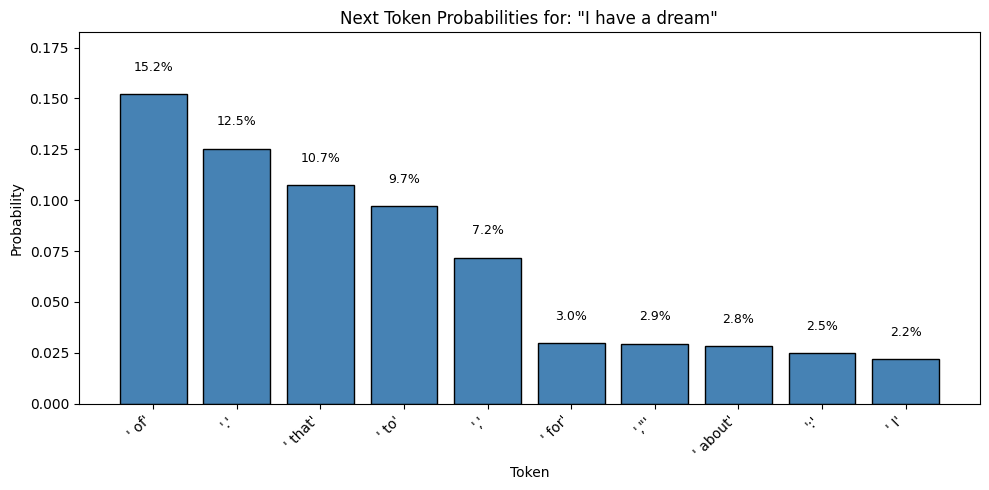

In [13]:
# Visualize the probability distribution
tokens = [f"'{t}'" for t, _ in results]
probs = [p for _, p in results]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(tokens, probs, color='steelblue', edgecolor='black')

ax.set_ylabel('Probability')
ax.set_xlabel('Token')
ax.set_title(f'Next Token Probabilities for: "{prompt}"')
ax.set_ylim(0, max(probs) * 1.2)

# Add probability labels on bars
for bar, prob in zip(bars, probs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{prob:.1%}', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Joint Probability of a Sequence

The probability of an entire sequence of tokens is the product of conditional probabilities:

$$P(w_1, w_2, \ldots, w_t) = \prod_{i=1}^{t} P(w_i | w_1, \ldots, w_{i-1})$$

This is the **chain rule of probability** applied to language modeling. Each token's probability depends on all previous tokens.

### Exercise 1: Predict Before You Run

**Before running the cell below**, write down your predictions:

1. For the prompt `"The capital of France is"` — what token do you think will have the **highest** probability? What about second highest?

2. For the prompt `"I want to eat"` — will the top token have higher or lower probability than in the France example? Why?

**Your predictions:**
- France prompt, top token: _______________
- France prompt, top probability (guess): ___%
- Eat prompt, top probability higher/lower than France: _______________

Now run the cells and compare your predictions to reality.

In [14]:
def plot_token_probabilities(prompt, top_n=10):
    """
    Given a prompt, plot the top N most likely next tokens and their probabilities.
    """
    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt")
    
    # Get model outputs (logits)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract logits for the last token position
    logits = outputs.logits[0, -1, :]
    
    # Convert to probabilities using softmax
    probabilities = torch.softmax(logits, dim=0)
    
    # Get top N tokens
    top_probs, top_indices = torch.topk(probabilities, top_n)
    
    # Decode tokens
    results = []
    for prob, idx in zip(top_probs, top_indices):
        token = tokenizer.decode(idx)
        results.append((token, prob.item()))
    
    # Create bar chart
    tokens = [f"'{t}'" for t, _ in results]
    probs = [p for _, p in results]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(tokens, probs, color='steelblue', edgecolor='black')
    
    ax.set_ylabel('Probability')
    ax.set_xlabel('Token')
    ax.set_title(f'Next Token Probabilities for: "{prompt}"')
    ax.set_ylim(0, max(probs) * 1.2)
    
    # Add probability labels on bars
    for bar, prob in zip(bars, probs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{prob:.1%}', ha='center', va='bottom', fontsize=9)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


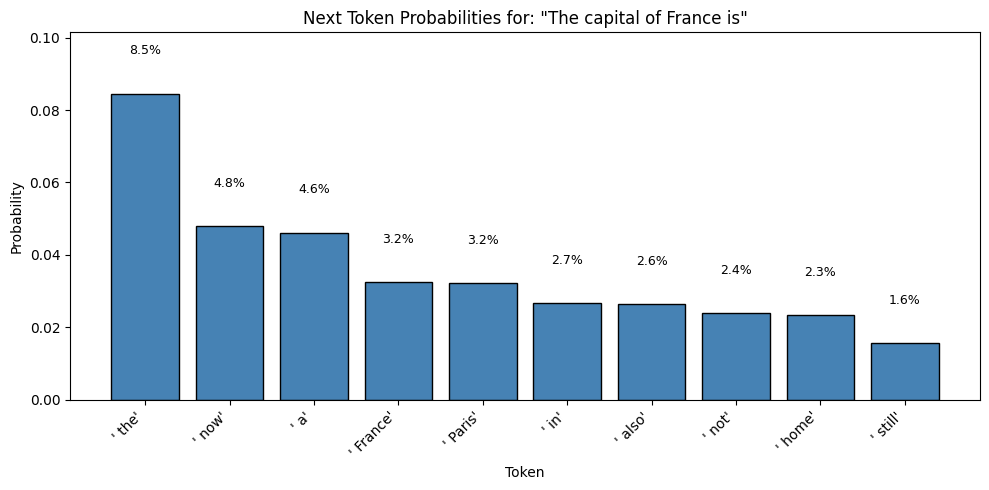

In [15]:
# Run this AFTER writing your predictions above
plot_token_probabilities("The capital of France is")

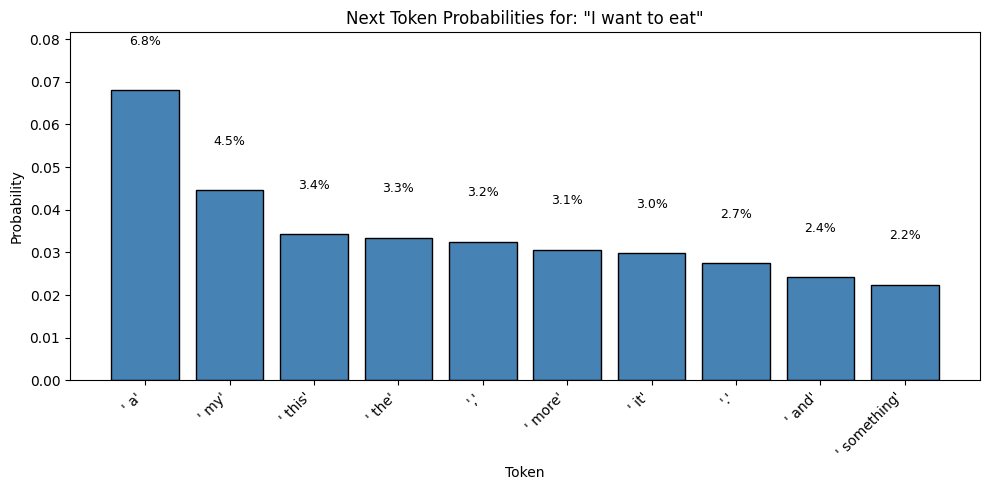

In [16]:
plot_token_probabilities("I want to eat")

**Reflection:** Were your predictions correct? What does the difference in probability distributions tell you about model "confidence"?

---

## 3. Greedy Search Decoding

### Theoretical Foundation

**Greedy Search** is the simplest decoding strategy. At each step, it selects the token with the **highest probability**:

$$w_t = \arg\max_{w} P(w | w_1, \ldots, w_{t-1})$$

This is what most users experience when using ChatGPT in a deterministic mode.



### How It Works

1. Start with the input prompt
2. Get probability distribution for the next token
3. Select the token with highest probability
4. Append it to the sequence
5. Repeat until a stopping condition is met

In [17]:
def get_next_token_probabilities(prompt, top_n=10):
    """
    Get the top N most likely next tokens for a given prompt.
    Returns a list of tuples: [(token, probability), ...]
    """
    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt")
    
    # Get model outputs (logits)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract logits for the last token position
    logits = outputs.logits[0, -1, :]
    
    # Convert to probabilities using softmax
    probabilities = torch.softmax(logits, dim=0)
    
    # Get top N tokens
    top_probs, top_indices = torch.topk(probabilities, top_n)
    
    # Decode tokens and return as list of tuples
    results = []
    for prob, idx in zip(top_probs, top_indices):
        token = tokenizer.decode(idx)
        results.append((token, prob.item()))
    
    return results


In [18]:
def greedy_decode_step_by_step(prompt, max_new_tokens=5):
    """
    Demonstrate greedy decoding step by step.
    Shows the probability of each selected token.
    """
    current_text = prompt
    steps = []
    
    print(f"Starting prompt: '{prompt}'\n")
    print("=" * 60)
    
    for step in range(max_new_tokens):
        # Get top token and its probability
        top_tokens = get_next_token_probabilities(current_text, top_n=1)
        next_token, probability = top_tokens[0]
        
        print(f"Step {step + 1}:")
        print(f"  Input: '{current_text}'")
        print(f"  Selected: '{next_token}' (probability: {probability:.2%})")
        
        current_text += next_token
        steps.append((next_token, probability))
        print(f"  Result: '{current_text}'")
        print("-" * 60)
    
    return current_text, steps

# Demonstrate greedy decoding
final_text, steps = greedy_decode_step_by_step("I have a dream", max_new_tokens=6)

Starting prompt: 'I have a dream'

Step 1:
  Input: 'I have a dream'
  Selected: ' of' (probability: 15.20%)
  Result: 'I have a dream of'
------------------------------------------------------------
Step 2:
  Input: 'I have a dream of'
  Selected: ' being' (probability: 9.68%)
  Result: 'I have a dream of being'
------------------------------------------------------------
Step 3:
  Input: 'I have a dream of being'
  Selected: ' a' (probability: 30.59%)
  Result: 'I have a dream of being a'
------------------------------------------------------------
Step 4:
  Input: 'I have a dream of being a'
  Selected: ' doctor' (probability: 2.86%)
  Result: 'I have a dream of being a doctor'
------------------------------------------------------------
Step 5:
  Input: 'I have a dream of being a doctor'
  Selected: '.' (probability: 22.93%)
  Result: 'I have a dream of being a doctor.'
------------------------------------------------------------
Step 6:
  Input: 'I have a dream of being a doctor.'

In [19]:
# Using Hugging Face's built-in greedy decoding
def generate_greedy(prompt, max_new_tokens=20):
    """Generate text using greedy decoding."""
    inputs = tokenizer(prompt, return_tensors="pt")
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,  # Greedy decoding
        pad_token_id=tokenizer.eos_token_id
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Greedy decoding output:")
print(generate_greedy("I have a dream", max_new_tokens=30))

Greedy decoding output:
I have a dream of being a doctor. I have a dream of being a doctor. I have a dream of being a doctor. I have a dream of being a


# Question:

Why is the sentence repeating??

### Limitations of Greedy Search

Greedy search has significant drawbacks:

1. **Local optima**: A high-probability token might lead to poor subsequent tokens
2. **Repetition**: Often produces repetitive text
3. **Lack of diversity**: Same input always produces same output
4. **Missing global optimum**: The best sequence might start with a lower-probability token

Notice in the visualization above how some tokens have quite low probabilities (like "being" at ~10%). Greedy search commits to these choices without exploring alternatives.

### Exercise 2: Predict Greedy Behavior

**Before running the cell below**, predict:

1. Will the output contain any repeated phrases after 100 tokens? (Yes/No)
2. If yes, roughly how many tokens before repetition starts? ___
3. Why might greedy decoding lead to repetition? (Write one sentence)

**Your prediction:** _________________________________

In [20]:
# Run AFTER making your prediction
long_output = generate_greedy("Once upon a time", max_new_tokens=100)
print(long_output)

Once upon a time, the world was a place of great beauty and great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the


### Contrast Question: Greedy vs. What Comes Next

You just observed greedy search's limitations. **Before moving to beam search**, answer:

1. The core problem with greedy search is that it commits to choices without exploring alternatives. **How might you fix this while still being deterministic?**

2. Would simply picking the *second* most likely token fix the repetition problem? Why or why not?

Write your answer before proceeding to Section 4.

---

## 4. Beam Search Decoding

### Theoretical Foundation

**Beam Search** addresses greedy search's local optima problem by maintaining multiple candidate sequences (called "beams") simultaneously.

At each step:
1. Expand each beam with all possible next tokens
2. Score all expanded sequences by their total probability
3. Keep only the top $k$ sequences (where $k$ is the "beam width")
4. Repeat until stopping conditions are met

### Why It Works

By keeping multiple candidates, beam search can recover from initially promising but ultimately poor paths. A sequence that starts with a lower-probability token might end up having higher total probability than one that starts greedily.

In [21]:
def generate_beam_search(prompt, max_new_tokens=20, num_beams=5, num_return_sequences=3):
    """Generate text using beam search."""
    inputs = tokenizer(prompt, return_tensors="pt")
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences,
        do_sample=False,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    results = []
    for i, output in enumerate(outputs):
        text = tokenizer.decode(output, skip_special_tokens=True)
        results.append(text)
    
    return results


In [22]:
import torch

def generate_beam_with_scores(prompt, max_new_tokens=30, num_beams=5, num_return_sequences=3):
    inputs = tokenizer(prompt, return_tensors="pt")

    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences,
        do_sample=False,
        early_stopping=True,
        output_scores=True,
        return_dict_in_generate=True,
        pad_token_id=tokenizer.eos_token_id,
    )

    results = []
    # sequences_scores exists for beam search
    for seq, score in zip(out.sequences, out.sequences_scores):
        text = tokenizer.decode(seq, skip_special_tokens=True)
        results.append((float(score), text))

    # Higher score is better (less negative)
    results.sort(key=lambda x: x[0], reverse=True)
    return results

for score, text in generate_beam_with_scores("The animals", max_new_tokens=25, num_beams=5, num_return_sequences=3):
    print(f"\nScore: {score:.3f}\n{text}")



Score: -1.417
The animals were kept in a small cage, where they were kept for up to 24 hours.

The animals were kept in a

Score: -1.457
The animals were kept in a small cage, where they were kept for up to 24 hours. The animals were kept in a small cage

Score: -1.469
The animals were kept in a small cage, where they were kept for up to 24 hours.

The animals were then placed in


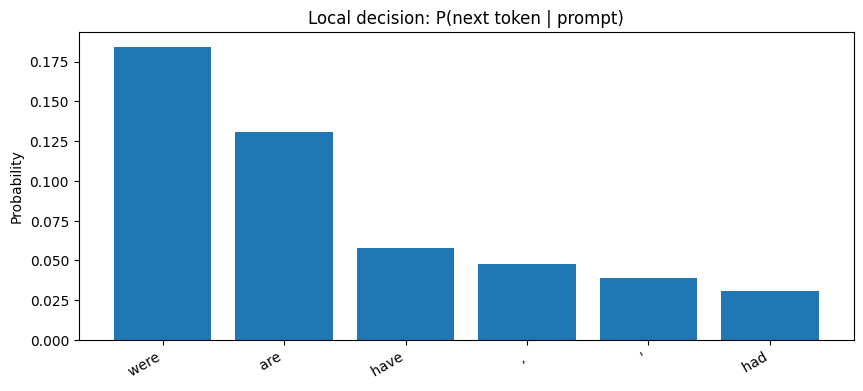

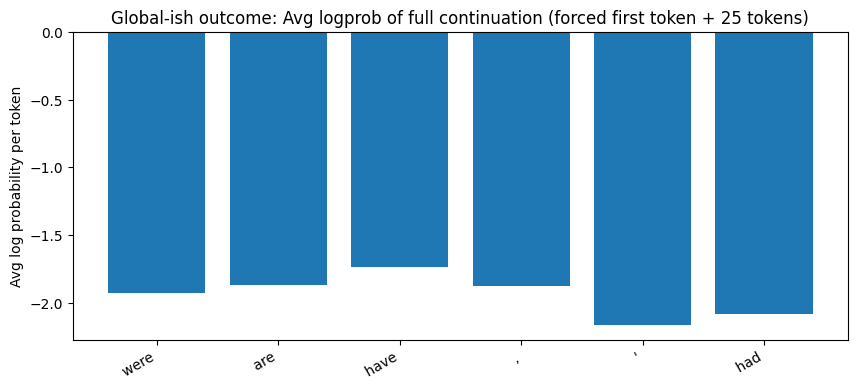

,token,p_next,avg_logprob,preview
0,were,0.184406,-1.923211,The animals were kept in a cage for about two ...
1,are,0.130554,-1.867926,"The animals are not allowed to eat the meat, b..."
2,have,0.057955,-1.732166,The animals have been kept in a cage for over ...
3,",",0.047869,-1.873841,"The animals, which are not known to have any k..."
4,',0.038668,-2.163475,The animals' lives were saved by the rescue te...
5,had,0.030484,-2.080585,The animals had been kept in a cage for about ...


In [23]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

def top_next_tokens(prompt, top_n=8):
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        out = model(**inputs)
    logits = out.logits[0, -1, :]
    probs = F.softmax(logits, dim=-1)
    top_probs, top_ids = torch.topk(probs, top_n)

    rows = []
    for p, tid in zip(top_probs.tolist(), top_ids.tolist()):
        tok = tokenizer.decode([tid])
        rows.append({"token_id": tid, "token": tok, "p_next": p})
    return pd.DataFrame(rows)

def logprob_sum_and_len(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        out = model(**inputs)
    logits = out.logits[0, :-1, :]            # predict next token at each position
    target = inputs["input_ids"][0, 1:]       # the actual next tokens

    log_probs = F.log_softmax(logits, dim=-1)
    token_logprobs = log_probs[torch.arange(target.shape[0]), target]
    return float(token_logprobs.sum()), int(target.shape[0])

def greedy_continue(text, max_new_tokens=20):
    inputs = tokenizer(text, return_tensors="pt")
    ids = model.generate(
        **inputs,
        do_sample=False,
        num_beams=1,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(ids[0], skip_special_tokens=True)

def visualize_local_vs_global(prompt, top_n=6, cont_tokens=25):
    df = top_next_tokens(prompt, top_n=top_n)

    results = []
    for _, row in df.iterrows():
        forced_first = prompt + row["token"]   # token usually includes leading space if needed
        full = greedy_continue(forced_first, max_new_tokens=cont_tokens)

        lp_sum, n = logprob_sum_and_len(full)
        results.append({
            "token": row["token"].replace("\n", "\\n"),
            "p_next": row["p_next"],
            "avg_logprob": lp_sum / n,         # average log prob per token (less negative is better)
            "preview": full[:120] + ("..." if len(full) > 120 else "")
        })

    res = pd.DataFrame(results).sort_values("p_next", ascending=False).reset_index(drop=True)

    # ---- Plot A: local next-token probability ----
    plt.figure(figsize=(10, 4))
    plt.bar(res["token"], res["p_next"])
    plt.xticks(rotation=30, ha="right")
    plt.title("Local decision: P(next token | prompt)")
    plt.ylabel("Probability")
    plt.show()

    # ---- Plot B: global continuation score ----
    plt.figure(figsize=(10, 4))
    plt.bar(res["token"], res["avg_logprob"])
    plt.xticks(rotation=30, ha="right")
    plt.title(f"Global-ish outcome: Avg logprob of full continuation (forced first token + {cont_tokens} tokens)")
    plt.ylabel("Avg log probability per token")
    plt.show()

    return res

# Try a prompt that has multiple plausible continuations:
res = visualize_local_vs_global("The animals", top_n=6, cont_tokens=25)
res[["token", "p_next", "avg_logprob", "preview"]]


In [24]:

# Compare greedy vs beam search
prompt = "I have a dream"

print("GREEDY DECODING:")
print(generate_greedy(prompt, max_new_tokens=25))
print("\n" + "=" * 60 + "\n")


GREEDY DECODING:
I have a dream of being a doctor. I have a dream of being a doctor. I have a dream of being a doctor. I have




In [25]:

print("BEAM SEARCH (num_beams=5, returning top 3):")
beam_results = generate_beam_search(prompt, max_new_tokens=25, num_beams=5, num_return_sequences=3)
for i, result in enumerate(beam_results):
    print(f"\nBeam {i+1}: {result}")

BEAM SEARCH (num_beams=5, returning top 3):

Beam 1: I have a dream. I have a dream. I have a dream. I have a dream. I have a dream. I have a dream

Beam 2: I have a dream. I have a dream. I have a dream. I dream. I dream. I dream. I dream. I dream

Beam 3: I have a dream. I have a dream. I have a dream. I have a dream. I dream. I dream. I dream.


### Beam Search with Length Penalty

Beam search tends to favor shorter sequences (fewer multiplications = higher probability). We can counteract this with a **length penalty**:

$$\text{score} = \frac{\log P(y)}{|y|^\alpha}$$

Where $\alpha$ is the length penalty parameter:
- $\alpha > 1$: Encourages longer sequences
- $\alpha < 1$: Encourages shorter sequences
- $\alpha = 1$: Normalizes by length



Key idea:

> compare average probability per token instead of total probability

So now beam search asks:

> how good is each word on average?

instead of

"how short is the sentence?"

In [26]:
def compare_length_penalties(prompt, penalties=[0.5, 1.0, 2.0]):
    """Compare beam search outputs with different length penalties."""
    inputs = tokenizer(prompt, return_tensors="pt")
    
    print(f"Prompt: '{prompt}'\n")
    
    for penalty in penalties:
        outputs = model.generate(
            **inputs,
            max_new_tokens=30,
            num_beams=5,
            length_penalty=penalty,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
        text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f"Length penalty = {penalty}:")
        print(f"  {text}")
        print(f"  (Length: {len(text.split())} words)\n")

compare_length_penalties("The capital of France is")

Prompt: 'The capital of France is'

Length penalty = 0.5:
  The capital of France is the capital of France. It is the capital of France. It is the capital of France. It is the capital of France. It is the capital
  (Length: 31 words)

Length penalty = 1.0:
  The capital of France is the capital of France. It is the capital of France. It is the capital of France. It is the capital of France. It is the capital
  (Length: 31 words)

Length penalty = 2.0:
  The capital of France is the capital of France. It is the capital of France. It is the capital of France. It is the capital of France. It is the capital
  (Length: 31 words)



## Two key reasons:

1) We are using a causal LM (GPT-2) for a QA-style prompt

GPT-2 is not instruction-tuned. It often responds with “safe continuations” that match patterns in text, not factual answers. A tautology like:

“X is the capital of X”

is a very safe continuation statistically.

2) Beam search amplifies high-probability loops

Beam search finds the highest probability sequence, and repetitive loops often have very high probability token-by-token (because each next token becomes very predictable once the loop starts).

So beam search can be “better at repeating” than greedy.

Length penalty does not fix repetition. It only changes length preference.

### Exercise 3: Predict Beam Width Effects

**Before running**, predict:

1. As beam width increases (2 → 5 → 10 → 20), will the returned sequences become **more similar** or **more different** from each other?

2. Will beam width 20 produce noticeably "better" text than beam width 5?

3. What's the computational trade-off of larger beam widths?

**Your predictions:**
- Similarity trend: _______________
- Quality improvement with larger beams: Yes / No / Marginal
- Computational cost: _______________

In [27]:
# Run AFTER making predictions - try different beam widths
for beam_width in [2, 5, 10, 20]:
    results = generate_beam_search(
        "The future of artificial intelligence",
        max_new_tokens=25,
        num_beams=beam_width,
        num_return_sequences=min(3, beam_width)
    )
    print(f"\n{'='*50}")
    print(f"Beam width: {beam_width}")
    for i, result in enumerate(results):
        print(f"  {i+1}: {result}")


Beam width: 2
  1: The future of artificial intelligence is uncertain, but it's clear that it's going to change the way we think about the future of computing.


  2: The future of artificial intelligence is uncertain, but it's clear that it's going to change the way we think about the world.

The future

Beam width: 5
  1: The future of artificial intelligence is in the hands of the next generation of scientists and engineers.

The future of artificial intelligence is in the hands of
  2: The future of artificial intelligence is in the hands of the next generation of scientists and engineers.

"The future of artificial intelligence is in the hands
  3: The future of artificial intelligence is in the hands of the next generation of scientists and engineers.

The future of AI is in the hands of the

Beam width: 10
  1: The future of artificial intelligence is in the hands of the next generation of scientists and engineers.

The future of artificial intelligence is in the hands of
  2: 

### Contrast Question: Beam Search Limitations

Beam search explores multiple paths, but it's still **deterministic** — same input always gives same output.

**Answer before moving to Temperature:**

1. For a chatbot, is deterministic output desirable or problematic? Why?

2. Beam search finds high-probability sequences. Does high probability always mean high quality for creative tasks?

3. What would you need to add to get *different* outputs each time?

---

## 5. Temperature Scaling

### Theoretical Foundation

**Temperature** is a parameter that controls the "sharpness" of the probability distribution. It modifies the softmax function:

$$P(w_i) = \frac{e^{z_i / T}}{\sum_{j=1}^{V} e^{z_j / T}}$$

Where $T$ is the temperature:
- **$T < 1$ (Low temperature)**: Sharpens distribution, making high-probability tokens more dominant → More deterministic/conservative output
- **$T = 1$**: Original distribution (unchanged)
- **$T > 1$ (High temperature)**: Flattens distribution, giving lower-probability tokens more chance → More creative/random output
- **$T → 0$**: Approaches greedy decoding (argmax)

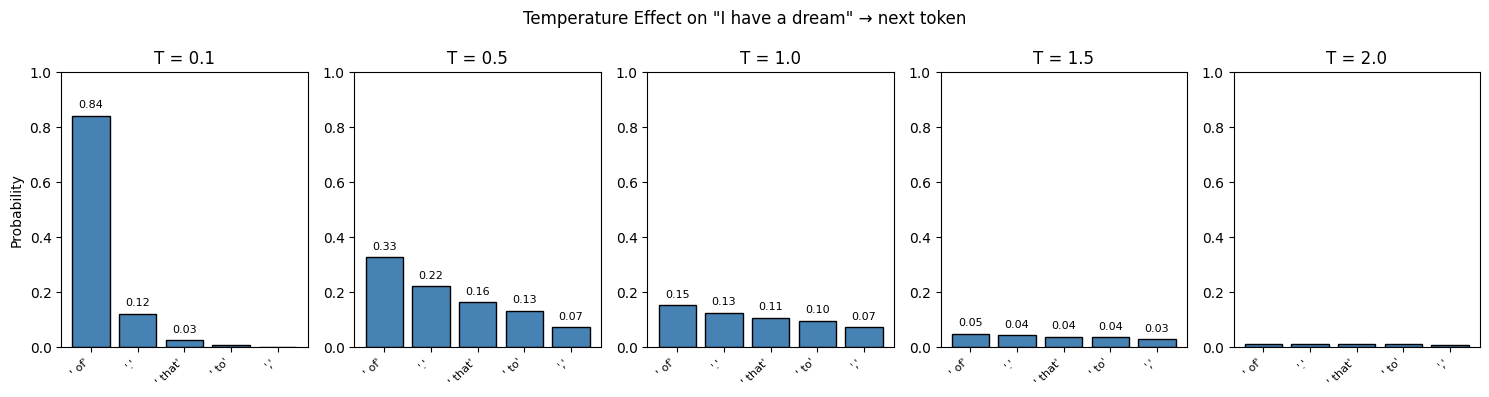

In [28]:
def apply_temperature(logits, temperature):
    """Apply temperature scaling to logits."""
    if temperature == 0:
        temperature = 1e-10  # Avoid division by zero
    return logits / temperature

def visualize_temperature_effect(prompt, temperatures=[0.1, 0.5, 1.0, 1.5, 2.0]):
    """Visualize how temperature affects probability distribution."""
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits[0, -1, :]
    
    # Get top 5 tokens at T=1 for consistent comparison
    base_probs = torch.softmax(logits, dim=0)
    _, top_indices = torch.topk(base_probs, 5)
    tokens = [tokenizer.decode(idx) for idx in top_indices]
    
    fig, axes = plt.subplots(1, len(temperatures), figsize=(15, 4))
    fig.suptitle(f'Temperature Effect on "{prompt}" → next token', fontsize=12)
    
    for ax, temp in zip(axes, temperatures):
        scaled_logits = apply_temperature(logits, temp)
        probs = torch.softmax(scaled_logits, dim=0)
        top_probs = probs[top_indices].numpy()
        
        bars = ax.bar(range(5), top_probs, color='steelblue', edgecolor='black')
        ax.set_xticks(range(5))
        ax.set_xticklabels([f"'{t}'" for t in tokens], rotation=45, ha='right', fontsize=8)
        ax.set_title(f'T = {temp}')
        ax.set_ylim(0, 1.0)
        ax.set_ylabel('Probability' if ax == axes[0] else '')
        
        for bar, prob in zip(bars, top_probs):
            if prob > 0.02:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        f'{prob:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

visualize_temperature_effect("I have a dream")

In [29]:
def generate_with_temperature(prompt, temperature, max_new_tokens=30):
    """Generate text with specified temperature."""
    inputs = tokenizer(prompt, return_tensors="pt")
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        pad_token_id=tokenizer.eos_token_id
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Compare different temperatures
prompt = "The meaning of life is"
temperatures = [0.3, 0.7, 1.0, 1.5]

print(f"Prompt: '{prompt}'\n")
print("=" * 60)

for temp in temperatures:
    print(f"\nTemperature = {temp}:")
    for i in range(2):  # Generate twice to show variation
        result = generate_with_temperature(prompt, temp, max_new_tokens=25)
        print(f"  Sample {i+1}: {result}")

Prompt: 'The meaning of life is'


Temperature = 0.3:
  Sample 1: The meaning of life is not to be understood by the average person. It is to be understood by the average person.

The meaning of life
  Sample 2: The meaning of life is to be free from all the passions of the world. The world is not a place for you to live. It is a

Temperature = 0.7:
  Sample 1: The meaning of life is the ultimate objective of all things. It is not just our survival as human beings, but the survival of our species as a
  Sample 2: The meaning of life is not just the question of the past. It is not just about what is right and what is wrong. It is about what

Temperature = 1.0:
  Sample 1: The meaning of life is clear, so he came to know that there was also a higher purpose, and he is said to have given all that he
  Sample 2: The meaning of life is not fixed." [p. 438]

This is hardly a new concept, and it isn't even new for

Temperature = 1.5:
  Sample 1: The meaning of life is about doing better when 

### Understanding Temperature Intuitively

| Temperature | Effect | Use Case |
|-------------|--------|----------|
| T = 0.1-0.3 | Very focused, nearly deterministic | Factual Q&A, code generation |
| T = 0.5-0.7 | Balanced creativity and coherence | General conversation |
| T = 1.0 | Original model distribution | Default behavior |
| T = 1.2-1.5 | More creative, surprising choices | Creative writing, brainstorming |
| T > 2.0 | Chaotic, often incoherent | Experimental only |

before we do any selection, Temperature is adjusted at softmax layer 

LLM produces logits - softmax layer produces - probabilities - selection steps 

what . generate does - selection (greedy or beam) , doing the probability , vary temperature, beams, 

### Exercise 4: Predict Temperature Effects on Tasks

**Before running**, predict the best temperature for each task:

| Task | Your Predicted Best Temperature |
|------|--------------------------------|
| Completing "The capital of Japan is" | ___ |
| Starting a fantasy story | ___ |
| Generating Python code | ___ |

**Reasoning:** Why did you choose different temperatures for different tasks?

In [30]:
# Run AFTER making predictions

# Task 1: Factual completion
factual_prompt = "The capital of Japan is"
print("FACTUAL TASK - Testing temperatures:")
for temp in [0.3, 0.7, 1.2]:
    print(f"  T={temp}: {generate_with_temperature(factual_prompt, temp, 10)}")

print("\n" + "=" * 50 + "\n")

# Task 2: Creative writing
creative_prompt = "In a world where dreams become reality,"
print("CREATIVE TASK - Testing temperatures:")
for temp in [0.3, 0.7, 1.2]:
    print(f"  T={temp}: {generate_with_temperature(creative_prompt, temp, 30)}")

FACTUAL TASK - Testing temperatures:
  T=0.3: The capital of Japan is the capital of the world's largest economy, and
  T=0.7: The capital of Japan is home to the largest Japanese community in the world,
  T=1.2: The capital of Japan is part of the vast Shido Peninsula, just as


CREATIVE TASK - Testing temperatures:
  T=0.3: In a world where dreams become reality, it's important to remember that we are all human beings, and we can't always be sure what we want to achieve.

"We're
  T=0.7: In a world where dreams become reality, it's up to you to decide what kind of music you want to make. There are certain types of music you'll want to hear and then there
  T=1.2: In a world where dreams become reality, those around you can help us face them.


-Join the Help Foundation and join our fight to bring peace and understanding for all youth.




### Contrast Question: Temperature vs. Correctness

**Critical thinking:**

1. Does temperature change the **correctness** of factual outputs, or just the **variety**? Look at your factual task results.

2. At T=0.3, did the model ever produce a *wrong* answer to "capital of Japan"? What about at T=1.5?

3. Temperature introduces randomness. Is randomness the same as creativity? What's the difference?

---

## 6. Top-K Sampling

### Theoretical Foundation

**Top-K Sampling** restricts token selection to the $K$ most probable tokens, then samples from this reduced set. The process:

1. Get probability distribution over all tokens
2. Keep only the top $K$ tokens
3. Re-normalize probabilities to sum to 1
4. Sample from this reduced distribution

### Mathematical Formulation

Given top-K tokens with original probabilities $p_1, p_2, \ldots, p_K$ where $p_1 \geq p_2 \geq \ldots \geq p_K$:

$$P'(w_i) = \frac{p_i}{\sum_{j=1}^{K} p_j}$$

### Example

If K=3 and probabilities are: A=30%, B=15%, C=5%, D=1%
- Keep: A, B, C (total: 50%)
- Re-normalized: A=60%, B=30%, C=10%

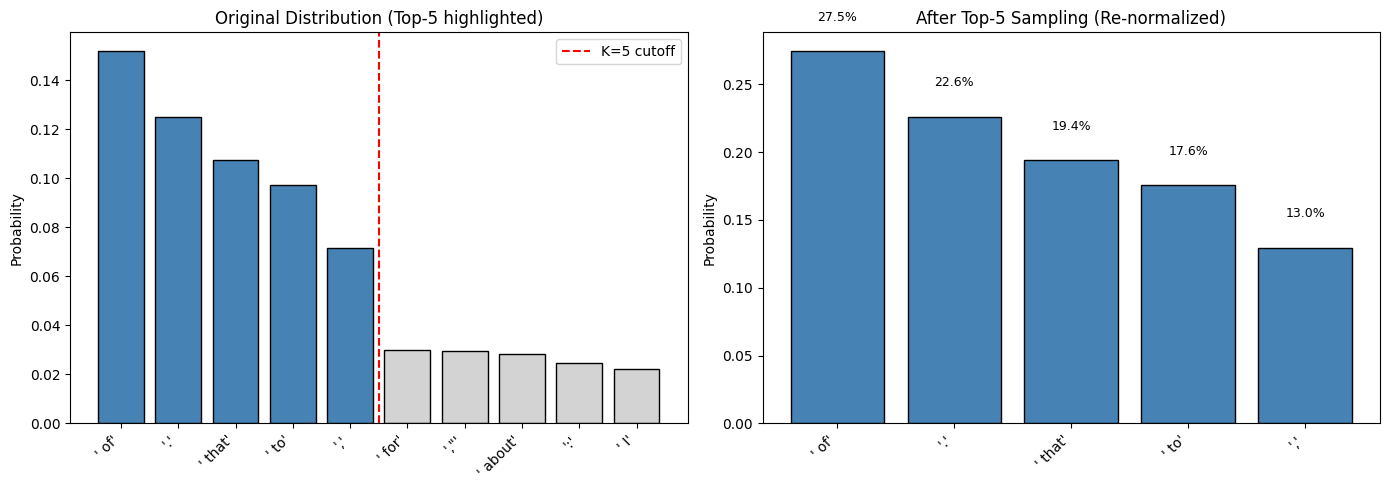


Top-K sum before normalization: 55.36%
Tokens excluded: 5 shown, potentially 50252 total


In [31]:
def demonstrate_top_k(prompt, k=5):
    """Visualize top-K sampling process."""
    # Get all probabilities
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits[0, -1, :]
    probs = torch.softmax(logits, dim=0)
    
    # Get top K and top K+5 for comparison
    top_probs, top_indices = torch.topk(probs, k + 5)
    tokens = [tokenizer.decode(idx) for idx in top_indices]
    
    # Calculate re-normalized probabilities for top-K
    top_k_sum = top_probs[:k].sum().item()
    renormalized = (top_probs[:k] / top_k_sum).numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Original distribution
    colors1 = ['steelblue' if i < k else 'lightgray' for i in range(k + 5)]
    bars1 = ax1.bar(range(k + 5), top_probs.numpy(), color=colors1, edgecolor='black')
    ax1.set_xticks(range(k + 5))
    ax1.set_xticklabels([f"'{t}'" for t in tokens], rotation=45, ha='right')
    ax1.set_title(f'Original Distribution (Top-{k} highlighted)')
    ax1.set_ylabel('Probability')
    ax1.axvline(x=k - 0.5, color='red', linestyle='--', label=f'K={k} cutoff')
    ax1.legend()
    
    # Re-normalized distribution
    bars2 = ax2.bar(range(k), renormalized, color='steelblue', edgecolor='black')
    ax2.set_xticks(range(k))
    ax2.set_xticklabels([f"'{t}'" for t in tokens[:k]], rotation=45, ha='right')
    ax2.set_title(f'After Top-{k} Sampling (Re-normalized)')
    ax2.set_ylabel('Probability')
    
    for bar, prob in zip(bars2, renormalized):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{prob:.1%}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop-K sum before normalization: {top_k_sum:.2%}")
    print(f"Tokens excluded: {k+5-k} shown, potentially {tokenizer.vocab_size - k} total")

demonstrate_top_k("I have a dream", k=5)

In [55]:
def generate_with_top_k(prompt, top_k, max_new_tokens=30):
    """Generate text with top-K sampling."""
    inputs = tokenizer(prompt, return_tensors="pt")
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Compare different K values
prompt = "The secret to happiness is"
k_values = [1, 5, 20, 50, 100]

print(f"Prompt: '{prompt}'\n")
print("=" * 60)

for k in k_values:
    print(f"\nTop-K = {k}:")
    result = generate_with_top_k(prompt, k, max_new_tokens=25)
    print(f"  {result}")

Prompt: 'The secret to happiness is'


Top-K = 1:
  The secret to happiness is to be happy.

The secret to happiness is to be happy.

The secret to happiness is to be happy

Top-K = 5:
  The secret to happiness is not the happiness of being happy but the happiness of being happy. It is the happiness of being happy.

The secret

Top-K = 20:
  The secret to happiness is not just to get a job but to get to know each other. You can have a long and happy relationship or the opposite

Top-K = 50:
  The secret to happiness is not your work, it's just your attitude. It's your attitude of, like, 'How do I get this feeling

Top-K = 100:
  The secret to happiness is finding it, not feeling that you're right. Life's not perfect.

No matter how much stuff happens, everyone


### Top-K Limitations

The fixed K value is both a strength and weakness:

**Problem**: If the model is very confident (e.g., one token has 95% probability), K=50 still includes 49 unlikely tokens. Conversely, if probabilities are flat (many tokens at ~5%), K=5 excludes many reasonable options.

This motivates **Nucleus Sampling** (Top-P), which we'll cover next.

### Exercise 5: Predict Top-K Diversity

**Before running**, predict:

1. With K=1, how many *unique* outputs will you get from 5 samples? ___

2. With K=100, will outputs be more coherent or less coherent than K=10? ___

3. Is there a K value where you get good diversity AND coherence? What might it be? ___

In [56]:
# Run AFTER predicting
test_prompt = "In the year 2050,"

for k in [1, 10, 100]:
    print(f"\n{'='*50}")
    print(f"K = {k}")
    outputs = [generate_with_top_k(test_prompt, k, 20) for _ in range(5)]
    unique_outputs = len(set(outputs))
    print(f"Unique outputs: {unique_outputs}/5")
    for i, out in enumerate(outputs[:3]):  # Show first 3
        print(f"  {i+1}: {out}")


K = 1
Unique outputs: 1/5
  1: In the year 2050, the world will have a population of about 1.5 billion people, and by 2050, the world
  2: In the year 2050, the world will have a population of about 1.5 billion people, and by 2050, the world
  3: In the year 2050, the world will have a population of about 1.5 billion people, and by 2050, the world

K = 10
Unique outputs: 5/5
  1: In the year 2050, it will be possible to develop a high density solar cell to replace coal-fired power plants. It
  2: In the year 2050, the world will be the only one in the world that has the same number of nuclear reactors and is
  3: In the year 2050, a total of 538 million people were living in cities, while only a fifth of them were working

K = 100
Unique outputs: 5/5
  1: In the year 2050, the rate will be 1.25 percent." The average U.S. birth rate: 10.
  2: In the year 2050, if I had to guess, I'd say to my neighbors, "You people probably have a better
  3: In the year 2050, scientists estimate the w

### Contrast Question: The Fixed-K Problem

**Think about this scenario:**

Prompt A: `"The capital of France is"` → Model is 90% confident in one token

Prompt B: `"I like to eat"` → Model has 5 tokens each around 15-20%

**Questions:**

1. If K=50 for both prompts, what's the problem for Prompt A?

2. If K=3 for both prompts, what's the problem for Prompt B?

3. What would an "adaptive K" look like — one that adjusts based on model confidence?

*(Hint: This leads directly to why Top-P sampling was invented)*

---

## 7. Nucleus (Top-P) Sampling

### Theoretical Foundation

**Nucleus Sampling** (also called Top-P sampling) dynamically selects the smallest set of tokens whose cumulative probability exceeds a threshold $p$.

### Algorithm

1. Sort tokens by probability (descending)
2. Compute cumulative probabilities
3. Find the smallest set where cumulative probability $\geq p$
4. Sample from this "nucleus"

### Why It's Better Than Top-K

The nucleus size adapts to the model's confidence:

**High confidence scenario** (P=0.9):
- Token A: 95% → Only A is in the nucleus!

**Low confidence scenario** (P=0.9):
- Tokens at 25%, 18%, 17%, 16%, 15% → All 5 needed to reach 90%

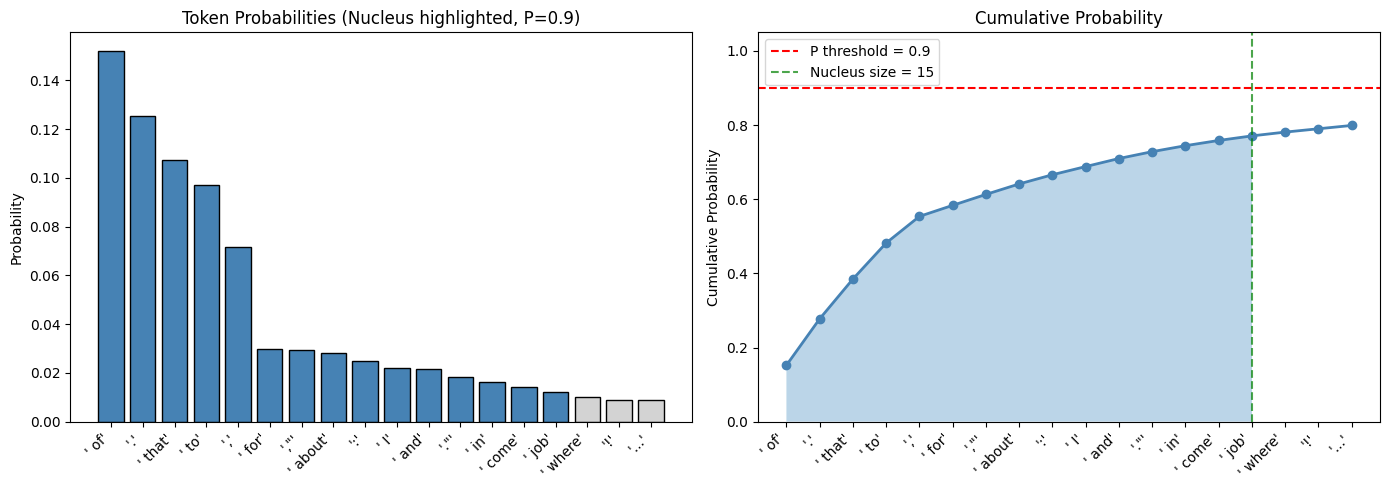


Nucleus contains 15 tokens
Combined probability: 77.07%


In [57]:
def demonstrate_nucleus_sampling(prompt, p=0.9):
    """Visualize nucleus (top-P) sampling process."""
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits[0, -1, :]
    probs = torch.softmax(logits, dim=0)
    
    # Sort and get cumulative probabilities
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumsum = torch.cumsum(sorted_probs, dim=0)
    
    # Find nucleus size
    nucleus_mask = cumsum <= p
    # Include one more token to exceed p
    nucleus_size = nucleus_mask.sum().item() + 1
    nucleus_size = min(nucleus_size, 15)  # Cap for visualization
    
    tokens = [tokenizer.decode(idx) for idx in sorted_indices[:nucleus_size + 3]]
    probs_to_show = sorted_probs[:nucleus_size + 3].numpy()
    cumsum_to_show = cumsum[:nucleus_size + 3].numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Individual probabilities
    colors = ['steelblue' if i < nucleus_size else 'lightgray' 
              for i in range(len(probs_to_show))]
    bars = ax1.bar(range(len(probs_to_show)), probs_to_show, color=colors, edgecolor='black')
    ax1.set_xticks(range(len(probs_to_show)))
    ax1.set_xticklabels([f"'{t}'" for t in tokens], rotation=45, ha='right')
    ax1.set_title(f'Token Probabilities (Nucleus highlighted, P={p})')
    ax1.set_ylabel('Probability')
    
    # Cumulative probabilities
    ax2.plot(range(len(cumsum_to_show)), cumsum_to_show, 'o-', color='steelblue', linewidth=2)
    ax2.axhline(y=p, color='red', linestyle='--', label=f'P threshold = {p}')
    ax2.axvline(x=nucleus_size - 1, color='green', linestyle='--', alpha=0.7, 
                label=f'Nucleus size = {nucleus_size}')
    ax2.fill_between(range(nucleus_size), cumsum_to_show[:nucleus_size], alpha=0.3)
    ax2.set_xticks(range(len(cumsum_to_show)))
    ax2.set_xticklabels([f"'{t}'" for t in tokens], rotation=45, ha='right')
    ax2.set_title('Cumulative Probability')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_ylim(0, 1.05)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nNucleus contains {nucleus_size} tokens")
    print(f"Combined probability: {cumsum_to_show[nucleus_size-1]:.2%}")

demonstrate_nucleus_sampling("I have a dream", p=0.9)


Prompt: 'The capital of France is'


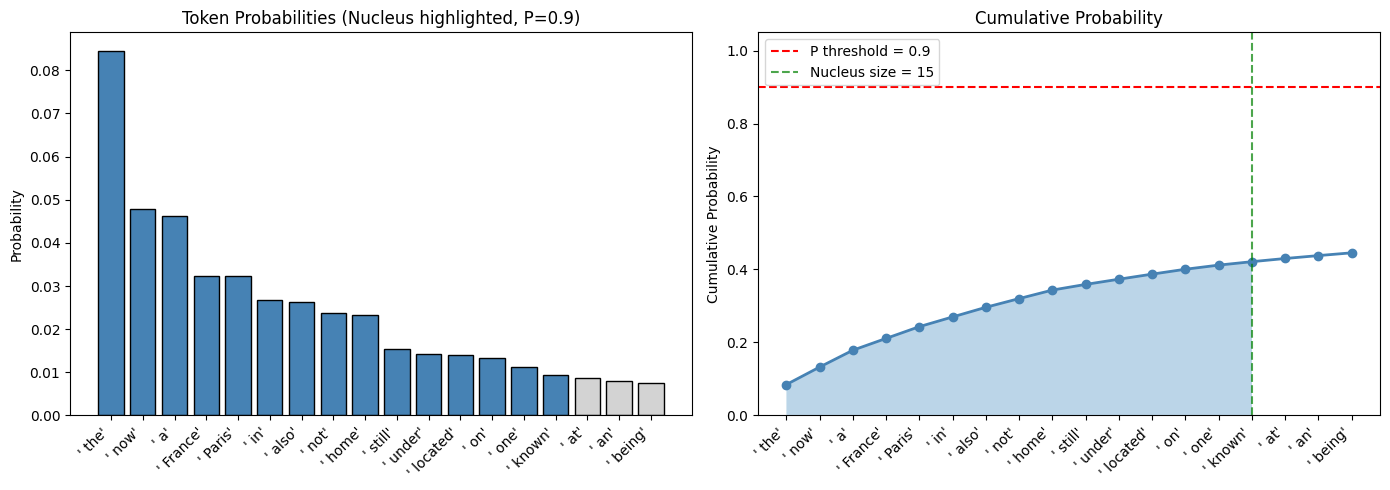


Nucleus contains 15 tokens
Combined probability: 42.14%

Prompt: 'I have a dream'


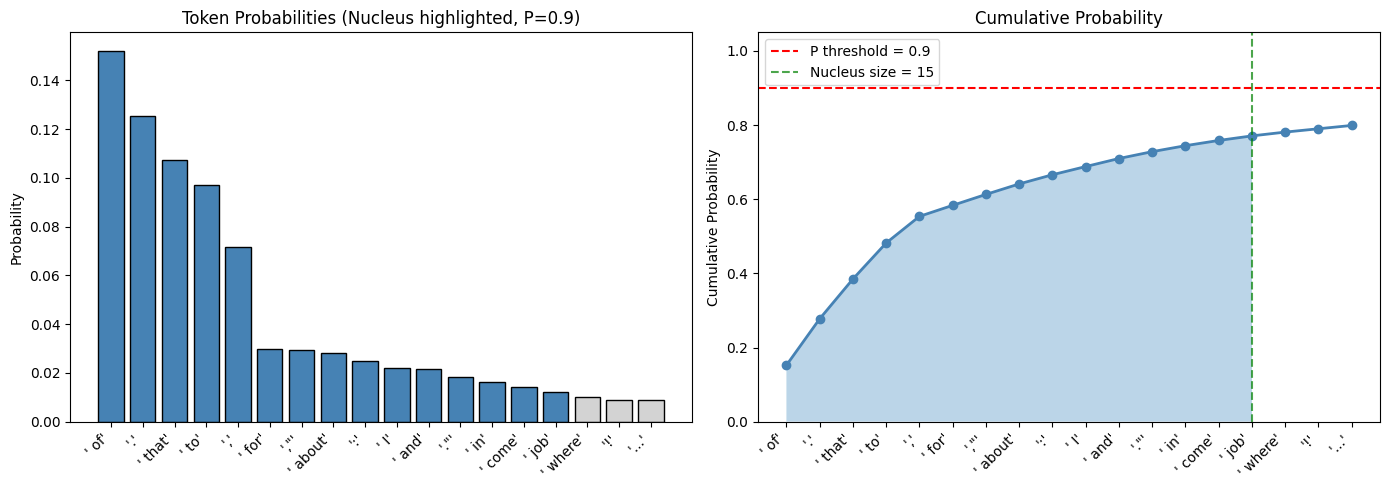


Nucleus contains 15 tokens
Combined probability: 77.07%

Prompt: 'The'


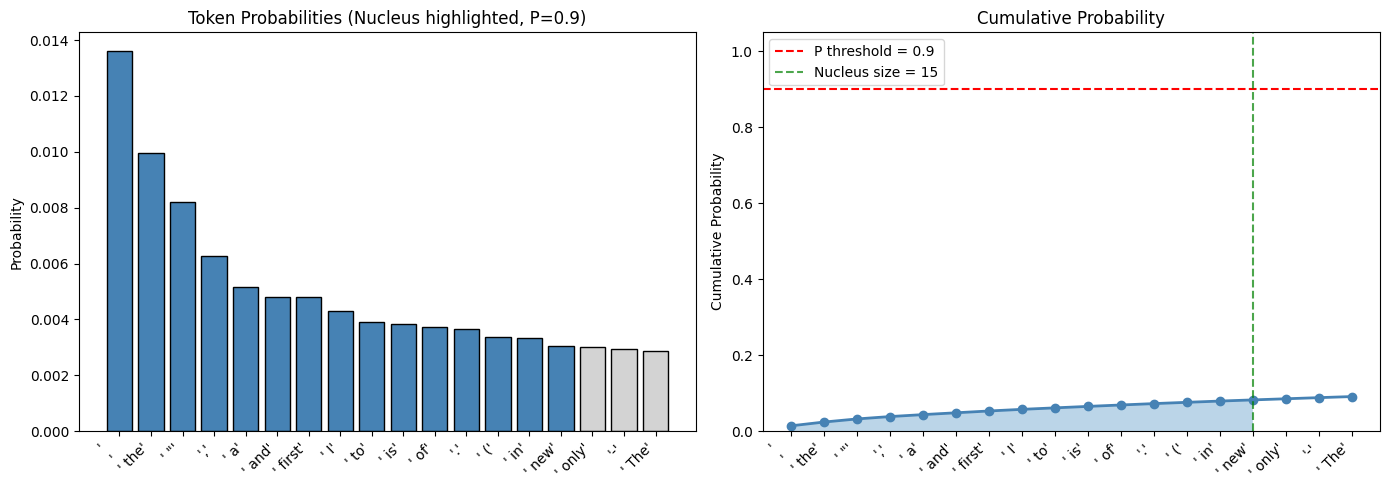


Nucleus contains 15 tokens
Combined probability: 8.20%


In [58]:
# Compare nucleus sizes for different prompts
prompts = [
    "The capital of France is",  # High confidence expected
    "I have a dream",            # Medium confidence
    "The"                        # Low confidence (many options)
]

for prompt in prompts:
    print(f"\nPrompt: '{prompt}'")
    demonstrate_nucleus_sampling(prompt, p=0.9)

In [59]:
def generate_with_nucleus(prompt, top_p, max_new_tokens=30):
    """Generate text with nucleus (top-P) sampling."""
    inputs = tokenizer(prompt, return_tensors="pt")
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=top_p,
        top_k=0,  # Disable top-K when using top-P
        pad_token_id=tokenizer.eos_token_id
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Compare different P values
prompt = "The most important thing in life is"
p_values = [0.5, 0.7, 0.9, 0.95, 1.0]

print(f"Prompt: '{prompt}'\n")
print("=" * 60)

for p in p_values:
    print(f"\nTop-P = {p}:")
    result = generate_with_nucleus(prompt, p, max_new_tokens=25)
    print(f"  {result}")

Prompt: 'The most important thing in life is'


Top-P = 0.5:
  The most important thing in life is to have a family. We have children and we're trying to find the right balance between the responsibilities of a father and the

Top-P = 0.7:
  The most important thing in life is to have a good heart. The hard part is knowing when you are going to need it most, and where you are going

Top-P = 0.9:
  The most important thing in life is that you don't really know what you want. That's so tricky, but if you start reaching for the answers, it

Top-P = 0.95:
  The most important thing in life is to move yourself. And then, when you go outside, send some stickers. Make sure to make sure the pieces are perfectly

Top-P = 1.0:
  The most important thing in life is focus. If a girl gets bored trying to score lines and four-line problems, it's a waste of time and distracting


### Exercise 6: Predict Top-P Adaptivity

**Before running**, think about these two prompts:

- Prompt A: `"2 + 2 ="` (highly constrained)
- Prompt B: `"My favorite"` (wide open)

**Predict:**

1. For P=0.9, approximately how many tokens will be in the nucleus for Prompt A? ___

2. For P=0.9, approximately how many tokens will be in the nucleus for Prompt B? ___

3. This is the key advantage of Top-P over Top-K. Can you articulate it in one sentence?

Prompt A: '2 + 2 =' (constrained)


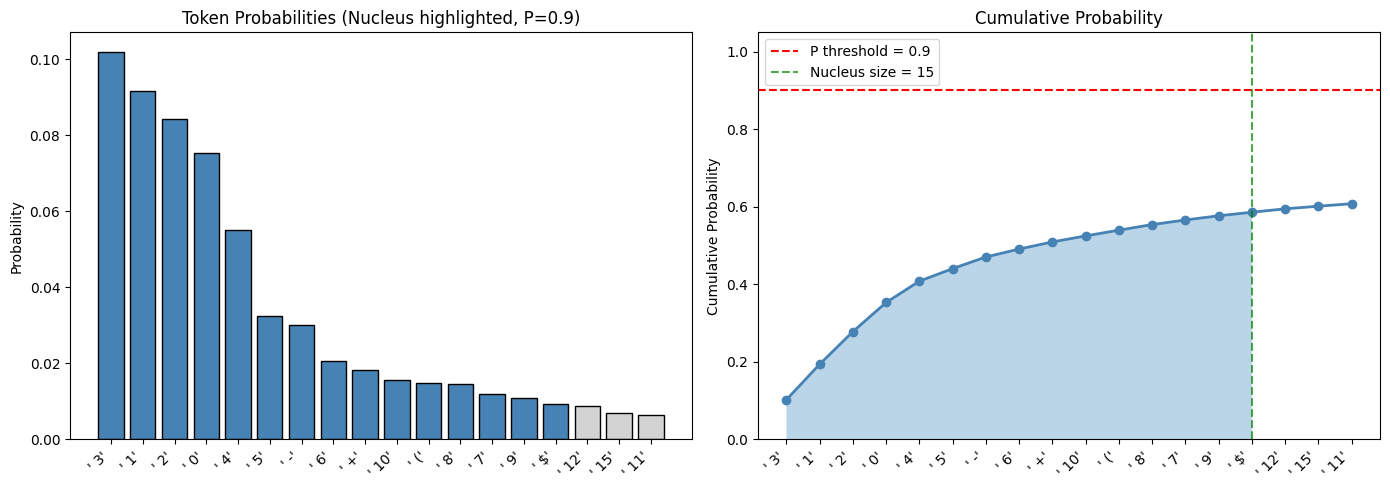


Nucleus contains 15 tokens
Combined probability: 58.58%


Prompt B: 'My favorite' (open-ended)


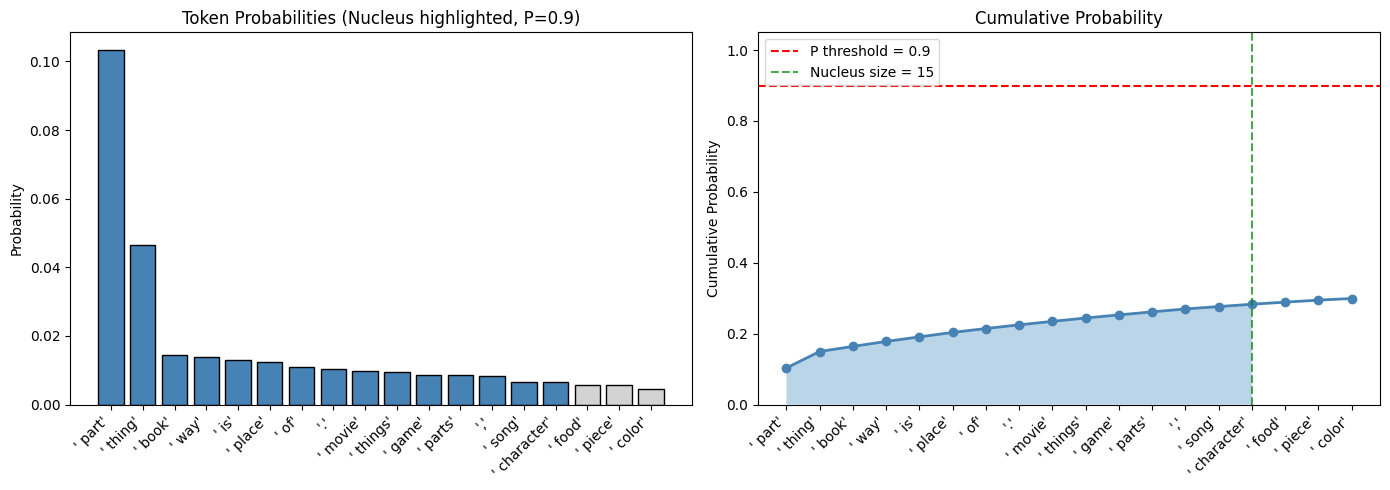


Nucleus contains 15 tokens
Combined probability: 28.31%


In [60]:
# Run AFTER predicting
print("Prompt A: '2 + 2 =' (constrained)")
demonstrate_nucleus_sampling("2 + 2 =", p=0.9)

print("\n" + "="*60 + "\n")

print("Prompt B: 'My favorite' (open-ended)")
demonstrate_nucleus_sampling("My favorite", p=0.9)

### Contrast Question: When is Top-P Safer Than Top-K?

You now understand both methods. **Answer:**

1. Give an example prompt where Top-K=50 would include many "bad" tokens that Top-P=0.9 would exclude.

2. Give an example prompt where Top-K=5 would exclude reasonable tokens that Top-P=0.9 would include.

3. A colleague says "Just use Top-K=40, it works fine." How would you convince them to try Top-P instead?

---

## 8. Common Pitfalls and Troubleshooting

| Problem | Likely Cause | Solution |
|---------|--------------|----------|
| Repetitive output | Greedy decoding or low temperature | Increase temperature, use sampling, add repetition penalty |
| Incoherent/random text | Temperature too high or P/K too high | Lower temperature (0.7-0.9), reduce P (0.9) or K (50) |
| Boring/predictable text | Temperature too low or greedy | Increase temperature, enable sampling |
| Text cuts off mid-sentence | max_new_tokens too low | Increase max_new_tokens, use length penalty |
| Same output every time | do_sample=False or temperature=0 | Set do_sample=True with temperature > 0 |
| Very short outputs | Length penalty too high or beam search bias | Reduce length_penalty, try sampling methods |
| Gibberish tokens | Corrupted model or wrong tokenizer | Verify model/tokenizer match, redownload model |

In [61]:
# Demonstration: Fixing repetition with repetition penalty
def generate_with_repetition_penalty(prompt, penalty=1.0, max_new_tokens=50):
    """Generate text with repetition penalty."""
    inputs = tokenizer(prompt, return_tensors="pt")
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,  # Greedy to show repetition
        repetition_penalty=penalty,
        pad_token_id=tokenizer.eos_token_id
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

prompt = "The quick brown fox"

print("Without repetition penalty (1.0):")
print(generate_with_repetition_penalty(prompt, penalty=1.0))

print("\nWith repetition penalty (1.2):")
print(generate_with_repetition_penalty(prompt, penalty=1.2))

Without repetition penalty (1.0):
The quick brown foxes are a great way to get a little bit of a kick out of your dog.

The quick brown foxes are a great way to get a little bit of a kick out of your dog. The quick brown foxes are a great

With repetition penalty (1.2):
The quick brown foxes are a great way to get some of the best food out there.
I've been using this for about 2 years now and I love it! It's so easy to make, you can even add in your own veggies or fruit if desired


---

## 9. Stress Test: Breaking the Model

So far, you've seen decoding strategies work on "nice" prompts. But real-world inputs are messy. This section tests how different strategies handle adversarial or unusual inputs.

### The Challenge Prompts

These prompts are designed to expose weaknesses in decoding strategies:

In [62]:
# Challenge prompts that stress-test decoding
challenge_prompts = {
    "repetitive_input": "The the the the the",
    "numeric_pattern": "1 2 3 4 5 6 7 8 9",
    "famous_quote": "In 1492 Columbus sailed the ocean",
    "gibberish": "Flurp snazzle wibble wobble",
    "single_word": "The"
}

### Exercise 7: Predict Failure Modes

**Before running the tests**, predict which decoding strategy will handle each prompt best:

| Prompt | Will Greedy Fail? | Best Strategy? | Why? |
|--------|-------------------|----------------|------|
| "The the the the the" | Yes / No | _________ | _________ |
| "1 2 3 4 5 6 7 8 9" | Yes / No | _________ | _________ |
| "In 1492 Columbus sailed the ocean" | Yes / No | _________ | _________ |
| "Flurp snazzle wibble wobble" | Yes / No | _________ | _________ |
| "The" | Yes / No | _________ | _________ |

In [63]:
def stress_test_strategies(prompt, max_tokens=30):
    """Test all decoding strategies on a single prompt."""
    print(f"PROMPT: '{prompt}'")
    print("=" * 60)
    
    strategies = {
        "Greedy": lambda: generate_greedy(prompt, max_tokens),
        "Beam (n=5)": lambda: generate_beam_search(prompt, max_tokens, num_beams=5, num_return_sequences=1)[0],
        "Temp=0.7": lambda: generate_with_temperature(prompt, 0.7, max_tokens),
        "Top-K=50": lambda: generate_with_top_k(prompt, 50, max_tokens),
        "Top-P=0.9": lambda: generate_with_nucleus(prompt, 0.9, max_tokens),
    }
    
    for name, gen_fn in strategies.items():
        try:
            result = gen_fn()
            # Check for repetition
            words = result.split()
            repetition = len(words) - len(set(words))
            rep_flag = " [REPETITIVE]" if repetition > len(words) * 0.3 else ""
            print(f"{name:12}: {result}{rep_flag}")
        except Exception as e:
            print(f"{name:12}: ERROR - {e}")
    print()

In [64]:
# Run stress tests
for name, prompt in challenge_prompts.items():
    print(f"\n{'#'*60}")
    print(f"# TEST: {name}")
    print(f"{'#'*60}\n")
    stress_test_strategies(prompt)


############################################################
# TEST: repetitive_input
############################################################

PROMPT: 'The the the the the'
Greedy      : The the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the [REPETITIVE]
Beam (n=5)  : The the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the [REPETITIVE]
Temp=0.7    : The the the the the the that they will say that he is a man who does not know what he is doing. he will say that after he has committed adultery with his [REPETITIVE]
Top-K=50    : The the the the the was from the first few days to the second in terms of size, shape and age of the cvals was what we do. We want to
Top-P=0.9   : The the the the the is to now holding particle concept of immaterial nature, that the molecules inside some don't even know that they are human 

### Analysis Questions

After running the stress tests, answer:

1. **Which strategy degraded the least overall?** Why do you think that is?

2. **The repetitive input ("The the the the")**: Did any strategy recover and produce sensible text? What does this tell you about how LLMs handle unusual patterns?

3. **The numeric pattern**: Did the model continue the pattern or break it? Is pattern continuation always desirable?

4. **The famous quote**: Some strategies might complete it correctly ("blue"), others might not. What determines success here?

5. **The gibberish input**: What happened? Does this reveal anything about how LLMs "understand" input?

**Key Insight:** Write one sentence summarizing what you learned about decoding robustness from these tests.

---

## 10. Comparison of Decoding Strategies

| Strategy | Deterministic | Diversity | Coherence | Best For |
|----------|--------------|-----------|-----------|----------|
| Greedy | Yes | Low | Medium | Quick prototyping, simple completions |
| Beam Search | Yes | Low-Medium | High | Translation, summarization, factual tasks |
| Temperature | No | Tunable | Tunable | All generative tasks (with proper tuning) |
| Top-K | No | Medium | Medium-High | Creative writing with bounded randomness |
| Nucleus (Top-P) | No | Adaptive | High | Most generative tasks (recommended default) |

### Recommended Defaults

For most applications, start with:
- **Factual/precise tasks**: `temperature=0.3`, `top_p=0.9`
- **Balanced generation**: `temperature=0.7`, `top_p=0.9`
- **Creative tasks**: `temperature=1.0`, `top_p=0.95`

---

## 11. Practical Applications

### Chatbots and Conversational AI
Use nucleus sampling (P=0.9) with moderate temperature (0.7) for natural, varied responses while maintaining coherence.

### Code Generation
Use lower temperature (0.2-0.5) or greedy decoding for syntactically correct code. Beam search can help find optimal solutions.

### Creative Writing
Higher temperature (0.9-1.2) with top-P (0.95) produces creative, surprising text while avoiding complete randomness.

### Translation and Summarization
Beam search with length penalty works well for these structured tasks where accuracy is paramount.

### Question Answering
Low temperature greedy decoding ensures consistent, factual answers.

---

## 12. Bonus: Combining Strategies

In practice, you can combine multiple strategies for optimal results. Here's an example combining temperature, top-K, and top-P:

In [65]:
def generate_combined(prompt, temperature=0.8, top_k=50, top_p=0.9, max_new_tokens=50):
    """
    Generate text combining multiple decoding strategies.
    This is how many production systems work.
    """
    inputs = tokenizer(prompt, return_tensors="pt")
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        repetition_penalty=1.1,
        pad_token_id=tokenizer.eos_token_id
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Production-quality generation
prompt = "The future of artificial intelligence will"

print("Combined Strategy Output:")
print("(temperature=0.8, top_k=50, top_p=0.9, repetition_penalty=1.1)\n")

for i in range(3):
    result = generate_combined(prompt)
    print(f"Sample {i+1}:\n{result}\n")

Combined Strategy Output:
(temperature=0.8, top_k=50, top_p=0.9, repetition_penalty=1.1)

Sample 1:
The future of artificial intelligence will be the most interesting aspect for those interested in this topic, and it's important to keep your eyes open when you read on about them.
"I hope that someday we can put a stop point where AI is at least as good or better than

Sample 2:
The future of artificial intelligence will come from the use of machine learning techniques to generate a more accurate picture. Artificial Intelligence is rapidly becoming one of the most important topics in education and research, with some researchers proposing that it can be developed using computer-based AI systems (AIAs)

Sample 3:
The future of artificial intelligence will come as no surprise to those who have considered the topic. While many people believe that machine learning can't solve problems in everyday life, it has been suggested for decades by scientists and engineers alike that AI could be a so

---

## 13. Summary and Key Takeaways

### What We Learned

1. **Logits and Probabilities**: LLMs output raw scores (logits) that are converted to probabilities via softmax. The decoding strategy determines how we select from this distribution.

2. **Greedy Search**: Simple but limited. Always picks the highest probability token, leading to repetitive and potentially suboptimal sequences.

3. **Beam Search**: Maintains multiple candidates to find globally better sequences. Good for structured tasks but can still lack diversity.

4. **Temperature**: Scales the probability distribution. Lower = more focused/deterministic, higher = more creative/random.

5. **Top-K Sampling**: Limits selection to K most likely tokens. Simple but doesn't adapt to model confidence.

6. **Nucleus (Top-P) Sampling**: Dynamically selects tokens based on cumulative probability. Adapts to model confidence and is recommended for most tasks.

### Next Steps for Exploration

1. Experiment with different models (GPT-2 medium/large, GPT-Neo, LLaMA)
2. Explore **contrastive search** and other advanced methods
3. Learn about **guided generation** and constrained decoding
4. Study **speculative decoding** for faster inference
5. Investigate how these strategies affect different languages and domains

### Further Reading

- [Hugging Face Generation Documentation](https://huggingface.co/docs/transformers/generation_strategies)
- "The Curious Case of Neural Text Degeneration" (Holtzman et al., 2020) - Original Top-P paper
- "How to Generate Text" - Hugging Face Blog

---

## Final Exercise (Exercise 8): Build Your Own Generator

**Challenge**: Create a function that automatically selects the best decoding strategy based on the task type.

In [ ]:
def smart_generate(prompt, task_type="balanced", max_new_tokens=50):
    """
    Automatically select decoding parameters based on task type.
    
    task_type options:
    - 'factual': Low temperature, focused output
    - 'creative': High temperature, diverse output
    - 'balanced': Moderate settings (default)
    - 'code': Very low temperature, deterministic
    """
    inputs = tokenizer(prompt, return_tensors="pt")
    
    # Define presets for different tasks
    presets = {
        'factual': {'temperature': 0.3, 'top_p': 0.9, 'top_k': 40},
        'creative': {'temperature': 1.1, 'top_p': 0.95, 'top_k': 100},
        'balanced': {'temperature': 0.7, 'top_p': 0.9, 'top_k': 50},
        'code': {'temperature': 0.2, 'top_p': 0.85, 'top_k': 30}
    }
    
    params = presets.get(task_type, presets['balanced'])
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        **params,
        repetition_penalty=1.1,
        pad_token_id=tokenizer.eos_token_id
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test the smart generator
test_prompts = {
    'factual': "The chemical formula for water is",
    'creative': "In a world where colors could speak,",
    'balanced': "The best way to learn programming is",
    'code': "def fibonacci(n):"
}

for task, prompt in test_prompts.items():
    print(f"\n[{task.upper()}] {prompt}")
    print(smart_generate(prompt, task_type=task, max_new_tokens=30))


[FACTUAL] The chemical formula for water is
The chemical formula for water is the same as that used in cooking. It's a mixture of hydrogen and oxygen, which are both produced by bacteria living on surfaces like glass or wood

[CREATIVE] In a world where colors could speak,
